## Import libraries, util functions and test image loading



In [ ]:
# Importing working libraries
import os
import cv2
import imutils
import urllib3
import math as m
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy.ndimage import morphology
from scipy.ndimage import binary_dilation, binary_erosion

# *For Google Colab*
from google.colab import drive
from google.colab.patches import cv2_imshow

# Import from my google drive
drive.mount('/content/drive')

# Path
path_images = "/content/drive/MyDrive/Colab Notebooks/UAB Project/Computer Vision/UAB23-Computer-Vision-Labs/Lab 2/images"

# Load image path to test functions (comment if working in GC)
#path_images = "./images" # It doesn't work in google colab because the file management is different.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Block 2. Non-Linear Filtering and Morphological operations.

While linear filters can be effective for certain tasks, they often come with limitations when dealing with specific types of noise or when aiming to achieve certain effects on the image.

### Objectives:

1. **Median Filter Implementation**:
 Implement the median filter and understand its significance in noise removal.

2. **Defect detection with morphological operations**:
 Implement the basic morphological operations of dilation and erosion. Then implement the derived operations from these basics. After all this, propose pipelines to detect precisely the defects on some images.

3. **Watermarking**:
 Propose a pipeline for image watermarking using any of the previous techniques (Linear filtering, Non-linear filtering, Fourier transform, Morphological operations).

4. **Watermark extraction challenge (extra points)**
 Given three images with embedded watermarks of varying complexity levels, employ a combination of techniques seen in the course (image enhancing, linear filtering, non-linear filtering, morphological operations, and Fourier analysis) to extract the watermarks.
 You should obtain the binary mask with legible watermark for each image.

 ***Note***: The Challenge Exercise can augment your total grade **for up to 2 points**. For example, if you score 6 on this lab and complete the challenge, your score will be boosted up to 2 points, depending on the solution (0.5 easy; 0.5 medium; 1 hard). The total lab grade remains capped at 10 points.

---

### Mandatory Questions:

- How does the median filter differ in functionality from the mean filter, and under what circumstances is it preferable to use it?

  - Functionality: The mean filter replaces each pixel's intensity with the average of the pixel values in its neighborhood, while the median filter replaces the pixel intensity with the median value of the neighborhood.
  - Preference for Median Filter: The median filter is preferable when dealing with salt-and-pepper noise or outliers in an image. Unlike the mean filter, which can be sensitive to extreme values, the median filter is more robust in the presence of such outliers.

- Describe how a median filter works in the spatial domain.

  - The median filter works by traversing the image pixel by pixel with a kernel of specified size, often square. At each position, the values of the pixels included in the kernel are sorted, and the median value is selected to be the value of the kernel's central pixel in the filter's output image.

- How does the window size of the median filter affect the output image?

  - A larger window size in the median filter results in a stronger smoothing effect. However, excessively large window sizes can lead to loss of image details and introduce blurring. The choice of the window size depends on the characteristics of the noise and the desired level of smoothing.

- Can a median filter be implemented as a convolution operation? Explain why or why not.

  - The median filter is impossible to implement as a convolution operation, as it is a non-linear filter (taking the median element from neighboring values), unlike the mean filter.

- What are the basic morphological operations? Describe dilation and erosion in terms of structuring elements.

  - Dilation: It expands the shape of objects in an image. It is performed by moving a structuring element over the image and setting the pixel value to 1 if any of the overlapping pixels with the structuring element is 1.
  - Erosion: It shrinks the shape of objects. It sets a pixel to 1 only if all the overlapping pixels with the structuring element are 1.

- How do morphological operations change the shape and size of objects in an image?

  - Dilation increases the size of objects and fills in small gaps, while erosion decreases the size of objects and removes small protrusions. By combining dilation and erosion, various effects like opening (erosion followed by dilation) and closing (dilation followed by erosion) can be achieved.

- What are some common derived morphological operations and where they are used for?

  - Opening: Erosion followed by dilation. Useful for removing noise and separating objects that are close to each other.
  - Closing: Dilation followed by erosion. Useful for closing small gaps between objects and filling small holes.

- What is the purpose of watermarking in image processing?

  - Watermarking involves adding a message, logo, signature or data to an image. The aim is to make it possible to determine its provenance and origin, or to disimulate a message or information in the case of steganography.

- What is the difference between visible and invisible watermarks?

  - Visible: These are intentionally noticeable, often containing logos or text overlaid on the image.
  - Invisible: These are embedded in the image and are not easily perceptible, often requiring specialized tools for detection.

- How could you utilize Fourier Transform for watermark embedding?

  - The Fourier Transform can be used in watermarking by modifying the frequency domain of the image. Embedding information in the frequency domain can make the watermark more robust to certain types of image manipulations. Techniques include modifying the amplitude or phase information in the frequency domain. Detection involves analyzing the Fourier spectrum to retrieve the embedded watermark.


### Optional Deep Dive Questions:

- Beyond noise removal, can you think of any other applications where the median filter might be advantageous?
- Compare the computational complexity of median filtering with Gaussian filtering.
- Describe the process of top-hat and bottom-hat filtering. How can they be used for defect detection?
- Can morphological operations be applied to multi-channel images? Discuss the challenges.
- Discuss the concept of "hit-or-miss" transform in morphological operations. How can it be useful in defect detection?
- Explore the concept of morphological gradients. How can they be derived from the basic operations of erosion and dilation?
- In watermark extraction, are there any other techniques or methods (beyond the scope of this course) that might aid in making the extraction process more efficient or accurate? Research and discuss.
- Explore more robust watermarking and the techniques.

## Median filter

#### Objective:
Implement the median filter operation by hand and compare with linear blur filters.

---

#### Guideline:
1. Implement a function to perform the median filters over an image. Make sure to handle edge cases and allow for different kernel sizes. DO NOT USE LIBRARY IMPLEMENTATIONS.
2. Experiment with different kernel sizes and apply on various images.
3. Add different quantities of noise and analyze when an image is not recoverable.
4. Compare your hand-implemented method with libraries implementation.
5. Finally compare the median filter to the linear filter counterparts (gaussian / box filters) in order to explain how they differ.
---

#### Expected results:
- Your hand-implemented median filter.
- Qualitative comparison on different blurs

In [ ]:
def median_blur(image, kernel_size):

    # Checking parameters
    if not(isinstance(image, np.ndarray) or image is None):
        raise ValueError("The 'image' parameter must be a NumPy matrix")
    if not(len(image.shape) == 2):
      raise ValueError("The 'image' parameter must be in greyscale (3D -> 2D)")
    if not(image.shape[0] >= kernel_size[1] and image.shape[1] >= kernel_size[0]):
      raise ValueError("The 'kernel_size' size must be less than or equal to the image size in both dimensions")

    # Type conversion
    image = image.astype(np.float64)

    # Initialization of the output matrix
    output = np.zeros_like(image)

    # Half-kernel dimensions
    kh2,kw2 = kernel_size[1]//2,kernel_size[0]//2 # kernel_size = (kernel_width,kernel_height)

    # Iteration
    for i in range(0,output.shape[0]):
        for j in range(0,output.shape[1]):
            # Image region recovery
            image_region = image[i:i+kh2,j:j+kw2]
            # Calculating the scalar product between the image region and the kernel
            output[i,j] = np.median(image_region)

    # Result
    return output

Kernel size 5 processing in progress.
Kernel size 11 processing in progress.
Kernel size 15 processing in progress.
Kernel size 21 processing in progress.
Kernel size 25 processing in progress.


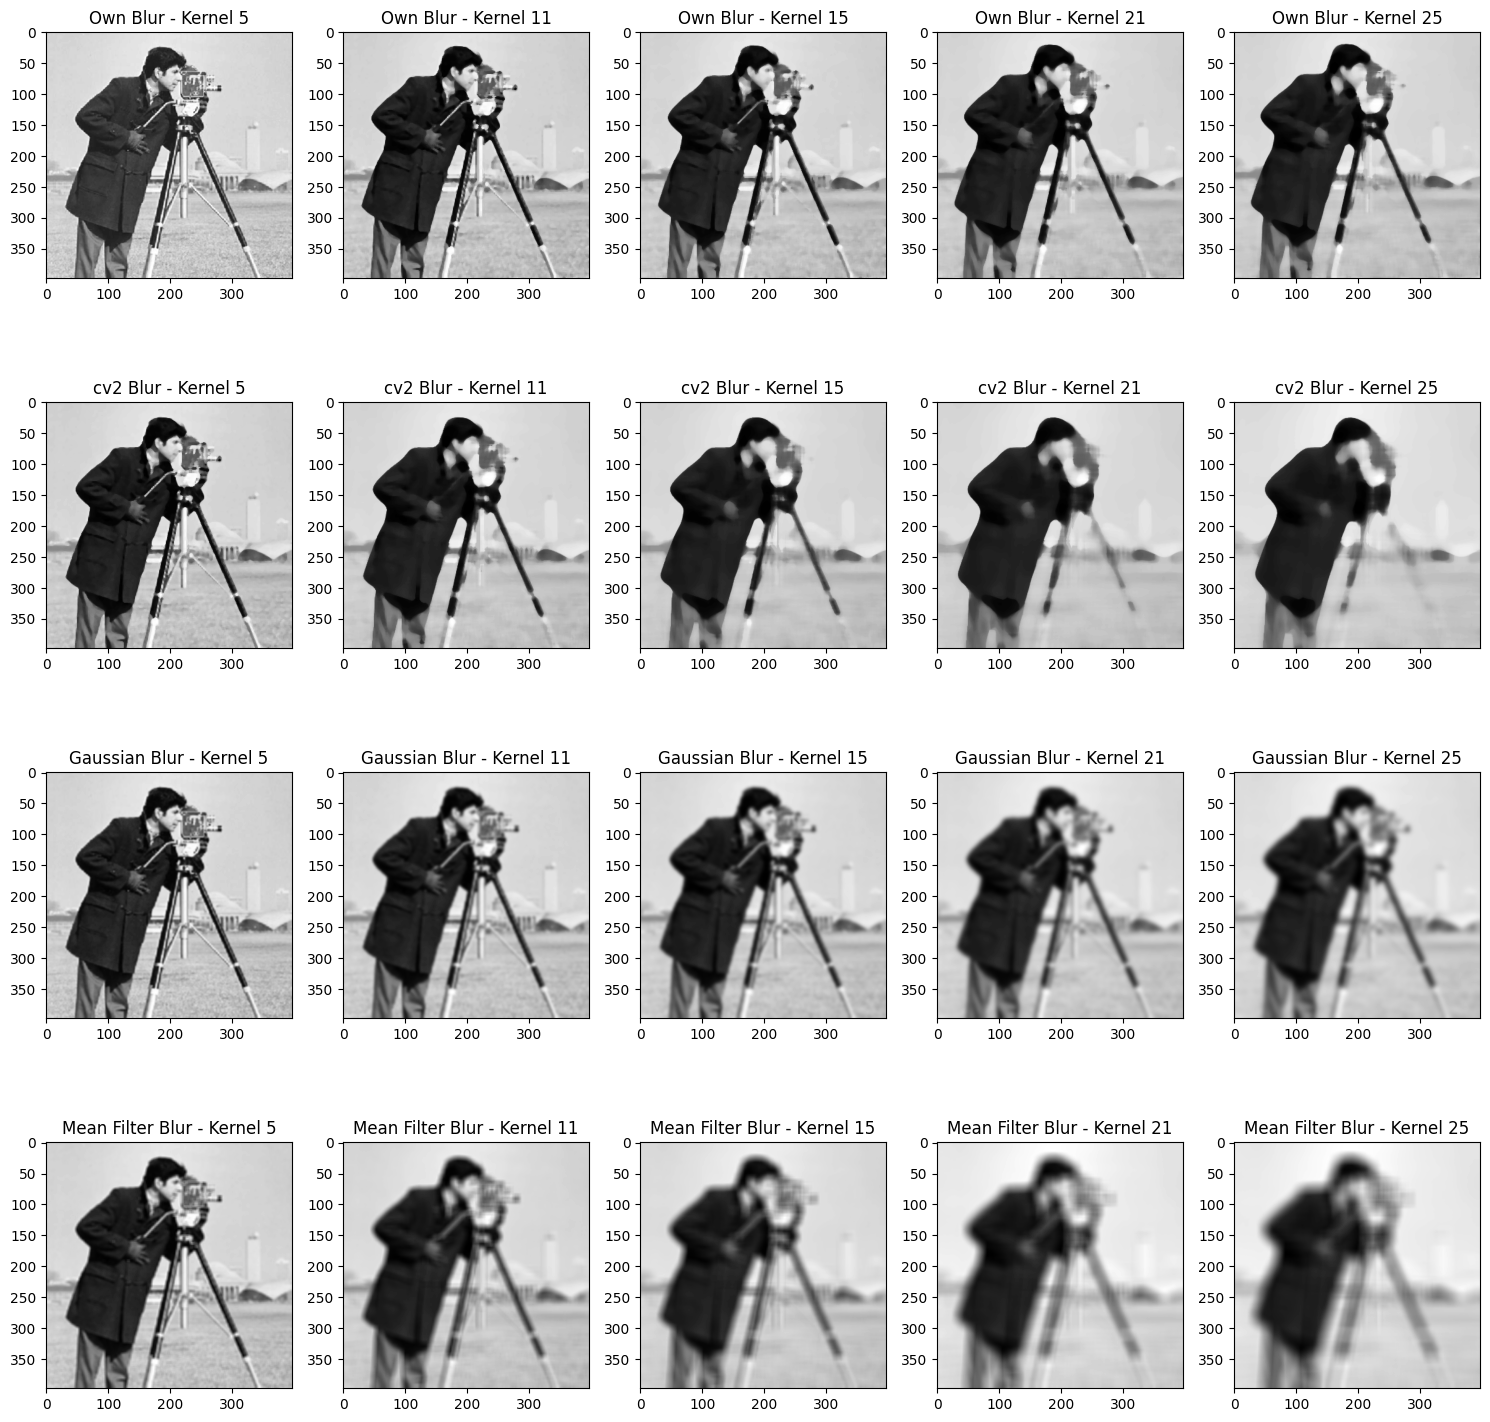

In [ ]:
# Image Preparation
path = os.path.join(path_images, "cameraman.png")
image_original = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# Applying median blur with different kernel sizes
kernel_sizes = list(range(5, 26, 5))

# Create a list of blur functions and their respective titles
blur_functions = [
    (median_blur, 'Own Blur'),
    (cv2.medianBlur, 'cv2 Blur'),
    (cv2.GaussianBlur, 'Gaussian Blur'),
    (cv2.boxFilter, 'Mean Filter Blur')
]

# Plotting the images
plt.figure(figsize=(15, 15))

for i, kernel_size in enumerate(kernel_sizes):
    # Ensure the kernel size is odd (for cv2)
    if kernel_size % 2 == 0:
        kernel_size += 1
    print(f"Kernel size {kernel_size} processing in progress.")

    for j, (blur_function, title) in enumerate(blur_functions):
        # Calculate blur
        if blur_function == median_blur:
            blur_image = median_blur(image_original, (kernel_size,kernel_size))
        elif blur_function == cv2.medianBlur:
            blur_image = cv2.medianBlur(image_original, kernel_size)
        elif blur_function == cv2.GaussianBlur:
            blur_image = cv2.GaussianBlur(image_original, (kernel_size, kernel_size), 0)
        elif blur_function == cv2.boxFilter:
            blur_image = cv2.boxFilter(image_original, -1, (kernel_size, kernel_size))

        # Plot the image
        plt.subplot(len(blur_functions), len(kernel_sizes), j * len(kernel_sizes) + i + 1)
        plt.imshow(blur_image, cmap='gray')
        plt.title(f'{title} - Kernel {kernel_size}')

plt.tight_layout()
plt.show()

## Morphological operators



#### Objective:
Implement the basic morphological operators seen in class and prove their properties.

Basic morphological operators:
 - Dilation
 - Erosion

Derived operations:   
 - Open
 - Close
 - Morphological gradient
 - Top hat (optional)
 - Bottom hat (optional)
 - Skeleton (optional)
 - Convex hull or perimeter (optional)

##### Prove each of the properties of dilation and erosion

- Translation Invariance (Dilation and Erosion)
- Anti-Extensive (Erosion)
- Extensive (Dilation)
- Idempotence (Open and Close)
- Monotonically increasing (Dilation and Erosion)

---

#### Guideline:
1. Implement a function to perform the erosion and dilation operations. DO NOT USE LIBRARY IMPLEMENTATIONS.
2. Implement the derived operations using the previous ones.
3. Apply different operators to dummy images and prove each of the properties of morphological operators.
4. Prove each one of the listed properties of erosion and dilation.

---

#### Expected results:
- Your hand-implemented functions for dilation, erosion, opening, closing & morphological gradient .
- Prove of each one of the properties (list them all)
- Example of each operation on dummy images (design your owns using openCV)

In [ ]:
# Dilation and Erosion

def dilation(image, structuring_element):
    height = image.shape[0] # Restructuring to force 2D image
    width = image.shape[1]
    s_height, s_width = structuring_element.shape
    pad_height, pad_width = s_height//2, s_width//2
    output = np.zeros_like(image)

    for i in range(0,height):
        for j in range(0,width):
            # Initialize the maximum value to the first pixel
            max_val = -np.inf #0
            for m in range(-pad_height,pad_height+1):
                for n in range(-pad_width,pad_width+1):
                    if structuring_element[m+pad_height][n+pad_width] == 1:
                      if (0<=i+m<=height-1) and(0<=j+n<=width-1):
                        max_val = max(max_val,image[i+m][j+n])
            output[i][j] = max_val

    return output

def erosion(image, structuring_element):
    height  = image.shape[0] # Restructuring to force 2D image
    width = image.shape[1]
    s_height, s_width = structuring_element.shape
    pad_height, pad_width = s_height//2, s_width//2
    output = np.zeros_like(image)

    for i in range(0,height):
        for j in range(0,width):
            # Initialize the minimum value to the first pixel
            min_val = np.inf #1
            for m in range(-pad_height,pad_height+1):
                for n in range(-pad_width,pad_width+1):
                    if structuring_element[m+pad_height][n+pad_width] == 1:
                      if (0<=i+m<=height-1) and(0<=j+n<=width-1):
                        min_val = min(min_val,image[i+m][j+n])
            output[i][j] = min_val

    return output

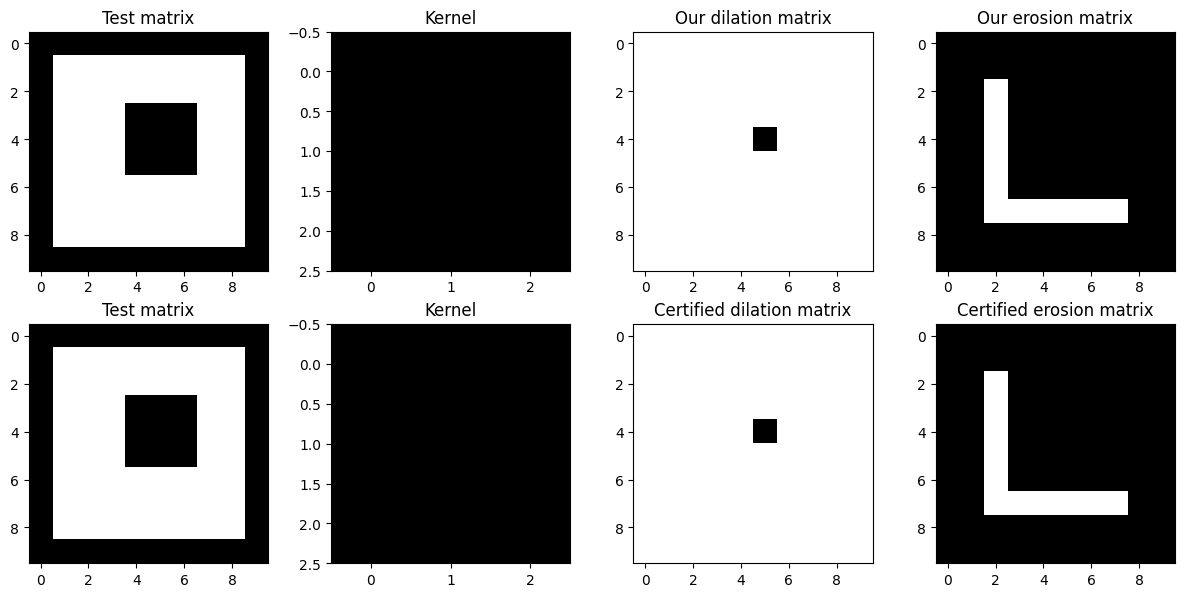

In [ ]:
# Dilation and erosion test on one example

test_matrix = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 1, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 1, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

kernel = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

# Matrix calculation
our_dilation_matrix = dilation(test_matrix, kernel)
our_erosion_matrix = erosion(test_matrix, kernel)
certified_dilation_matrix = binary_dilation(test_matrix, structure=kernel)
certified_erosion_matrix = binary_erosion(test_matrix, structure=kernel)

# Display preparation
our_matrix = [test_matrix, kernel, our_dilation_matrix, our_erosion_matrix,
              test_matrix, kernel, certified_dilation_matrix, certified_erosion_matrix]
titles = ["Test matrix", "Kernel", "Our dilation matrix", "Our erosion matrix",
          "Test matrix", "Kernel", "Certified dilation matrix", "Certified erosion matrix"]

# Display
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, (matrix, title) in enumerate(zip(our_matrix, titles)):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.imshow(matrix, cmap='gray')
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [ ]:
# Dilation and erosion test on several randomly generated examples

iteration_count = 20
for _ in range(iteration_count):
  # Initialization of test matrices
  random_image = np.random.randint(2, size=(200, 200))
  random_kernel = np.random.randint(2, size=(5, 5))
  # Matrix calculation
  our_dilation_matrix = dilation(test_matrix, kernel)
  our_erosion_matrix = erosion(test_matrix, kernel)
  certified_dilation_matrix = binary_dilation(test_matrix, structure=kernel)
  certified_erosion_matrix = binary_erosion(test_matrix, structure=kernel)
  # Equality test
  if np.array_equal(our_dilation_matrix, certified_dilation_matrix):
    print("Same dilation matrix")
  else:
    print("Different dilation matrix")
  if np.array_equal(our_erosion_matrix, certified_erosion_matrix):
    print("Same erosion matrix")
  else:
    print("Different erosion matrix")

Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix


In [ ]:
def opening(image, structuring_element):
    # Erosion followed by dilation
    eroded_image = erosion(image, structuring_element) # Removed 'structure=' argument
    opened_image = dilation(eroded_image, structuring_element) # Removed 'structure=' argument
    return opened_image

def closing(image, structuring_element):
    # Dilation followed by erosion
    dilated_image = dilation(image, structuring_element) # 'structure=' (?)
    closed_image = erosion(dilated_image, structuring_element) # 'structure=' (?)
    return closed_image

def top_hat(image, structuring_element):
    # Top hat is the original image minus the opening
    return image - opening(image, structuring_element)

def black_hat(image, structuring_element):
    # Black hat is the closing minus the original image
    return closing(image, structuring_element) - image

def morphological_gradient(image, structuring_element):
    # Morphological gradient is dilation minus erosion
    return dilation(image, structuring_element) - erosion(image, structuring_element)

def convex_hull(image):
    pass

def skeletonize(image):
    pass

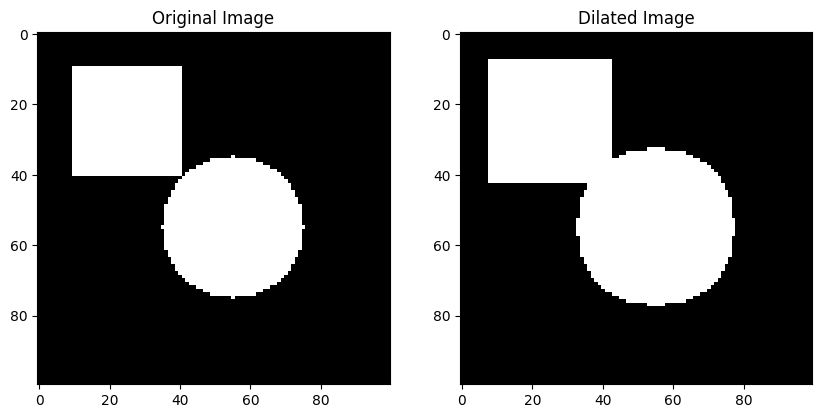

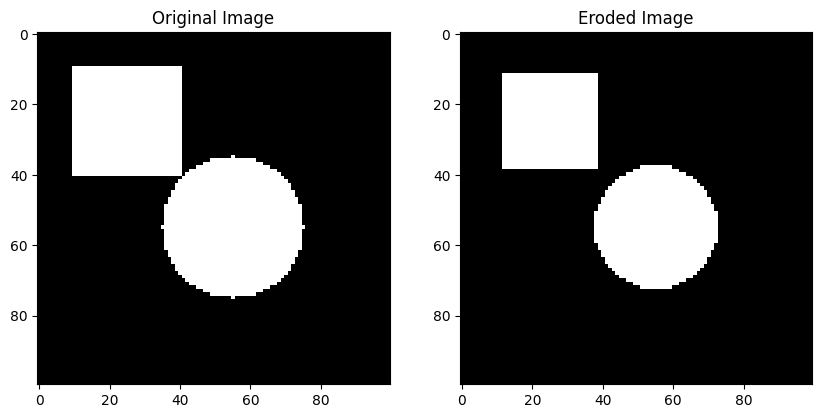

Translation Invariance (Dilation and Erosion)


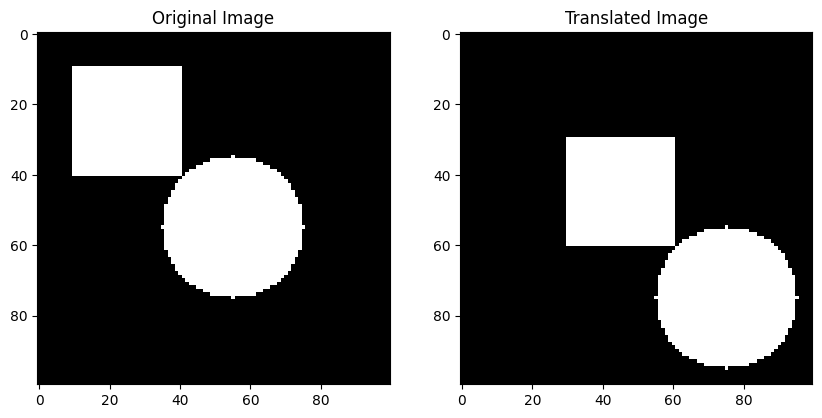

Translation Invariance (Dilation and Erosion)
Dilation


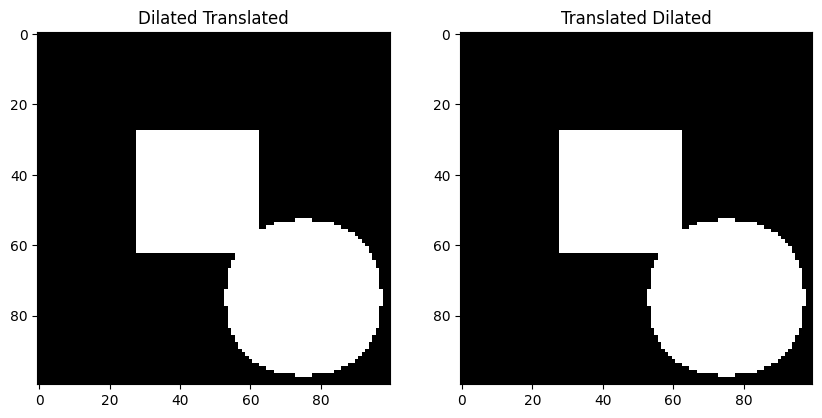

Erosion


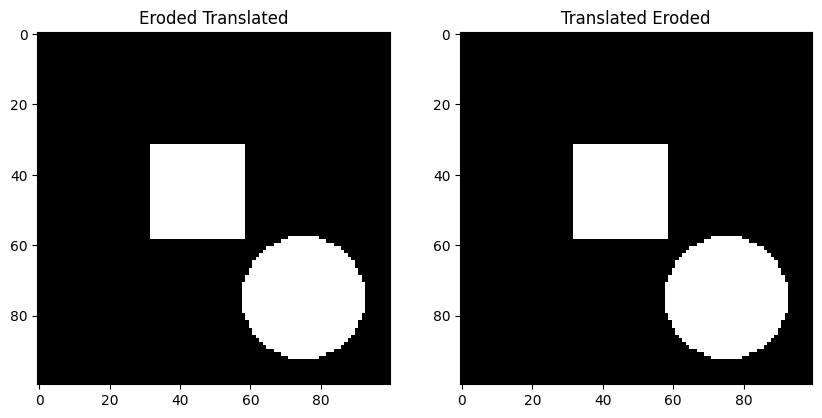

Anti-Extensive (Erosion) -> phy(X) included in X


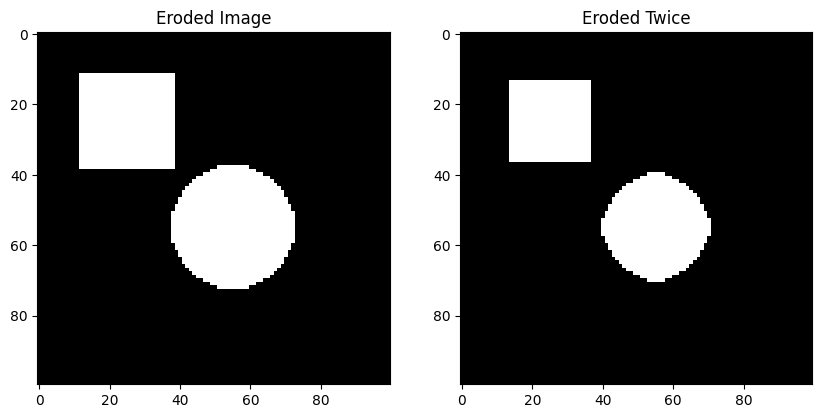

Extensive (Dilation) -> X included in phy(X)


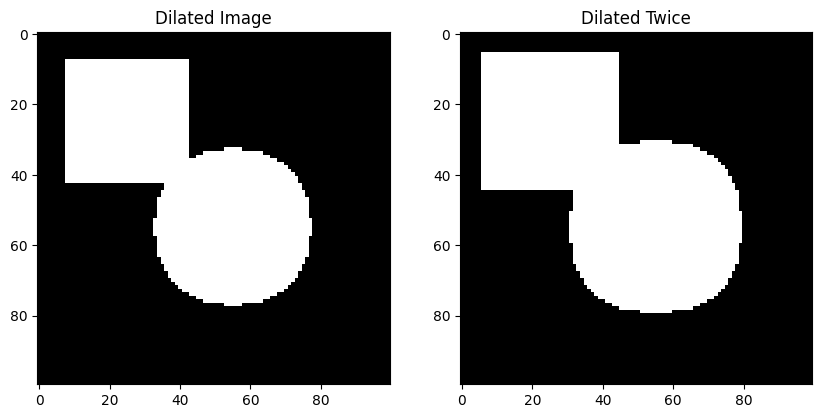

Idempotence (Open and Close) -> phy(phy(X)) = phy(X)
Opening


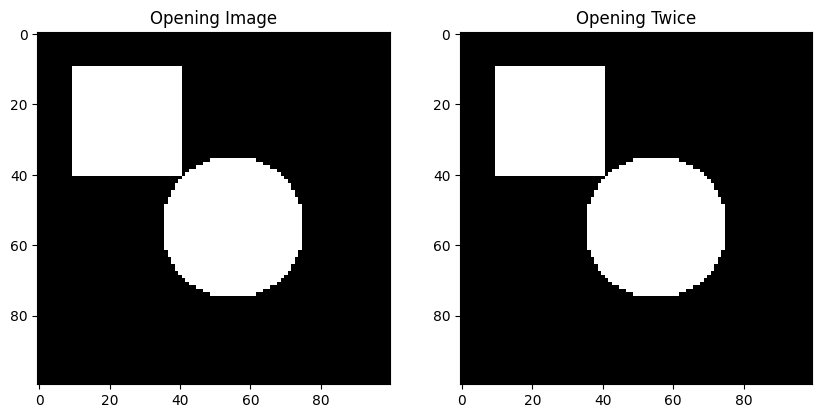

Closing


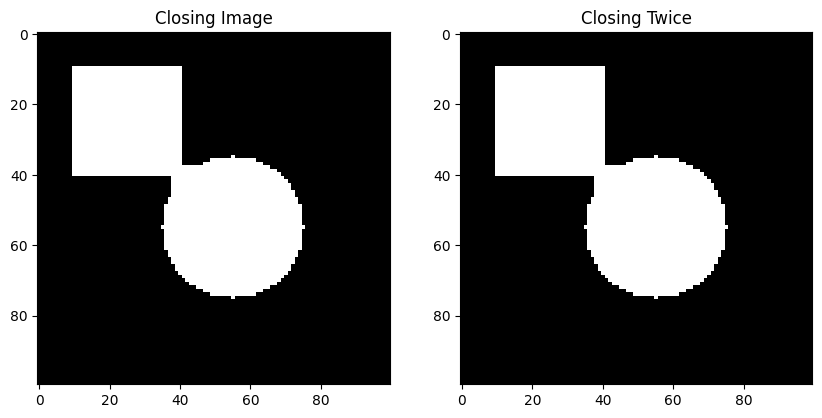

Monotonically increasing (Dilation and Erosion) -> Increasing the size of the structuring element results in a larger effect on the image.
Dilation


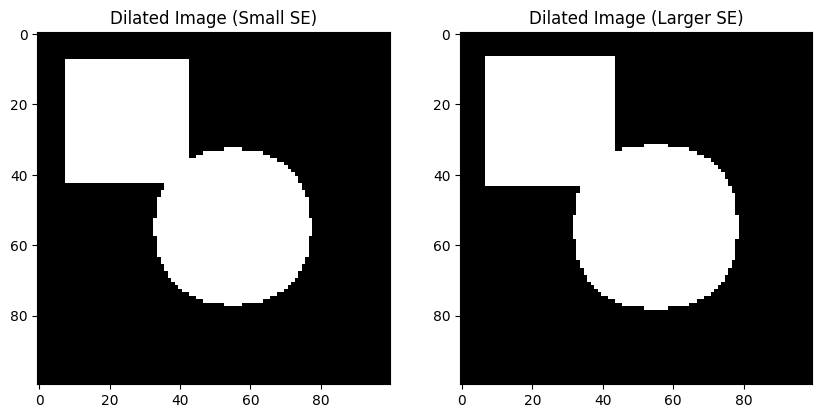

Erosion


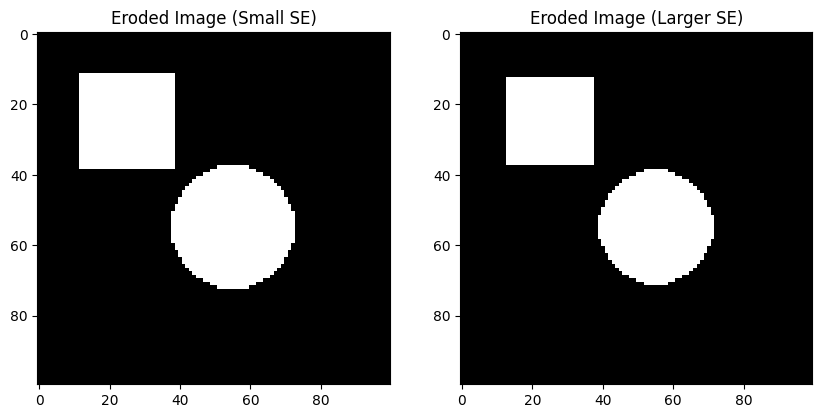

In [ ]:
# Demonstration of each property

# Display functions
def show_images(original, processed, title_original, title_processed):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title(title_original)

    plt.subplot(1, 2, 2)
    plt.imshow(processed, cmap='gray')
    plt.title(title_processed)

    plt.show()

# Generating an image
image = np.zeros((100, 100), dtype=np.uint8)
# Drawing geometric shapes
cv2.rectangle(image, (10, 10), (40, 40), 255, -1)  # Rectangle
cv2.circle(image, (55, 55), 20, 255, -1)  # Circle
# Generating the structuring element
structuring_element = np.ones((5, 5), dtype=np.uint8)

# Demonstration of properties
dilated_image = dilation(image, structuring_element)
eroded_image = erosion(image, structuring_element)
show_images(image, dilated_image, 'Original Image', 'Dilated Image')
show_images(image, eroded_image, 'Original Image', 'Eroded Image')

# Translation Invariance (Dilation and Erosion)
print("Translation Invariance (Dilation and Erosion)")
translation_matrix = np.float32([[1, 0, 20], [0, 1, 20]])  # Translate by (20, 20)
translated_image = cv2.warpAffine(image, translation_matrix, (100, 100)) # Image translation using cv2.warpAffine
show_images(image, translated_image, 'Original Image', 'Translated Image')
print("Translation Invariance (Dilation and Erosion)")
print("Dilation")
dilated_translated = dilation(translated_image, structuring_element)
translated_dilated = cv2.warpAffine(dilated_image, translation_matrix, (100, 100))
show_images(dilated_translated, translated_dilated, 'Dilated Translated', 'Translated Dilated')
print("Erosion")
eroded_translated = erosion(translated_image, structuring_element)
translated_eroded = cv2.warpAffine(eroded_image, translation_matrix, (100, 100))
show_images(eroded_translated, translated_eroded, 'Eroded Translated', 'Translated Eroded')

# Anti-Extensive (Erosion) -> phy(X) included in X
print("Anti-Extensive (Erosion) -> phy(X) included in X")
eroded_twice = erosion(eroded_image, structuring_element)
show_images(eroded_image, eroded_twice, 'Eroded Image', 'Eroded Twice')

# Extensive (Dilation) -> X included in phy(X)
print("Extensive (Dilation) -> X included in phy(X)")
dilated_twice = dilation(dilated_image, structuring_element)
show_images(dilated_image, dilated_twice, 'Dilated Image', 'Dilated Twice')

# Idempotence (Open and Close) -> phy(phy(X)) = phy(X)
print("Idempotence (Open and Close) -> phy(phy(X)) = phy(X)")
print("Opening")
image_opening = opening(image, structuring_element)
twice_opening = opening(image_opening, structuring_element)
show_images(image_opening, twice_opening, 'Opening Image', 'Opening Twice')
print("Closing")
image_closing = closing(image, structuring_element)
twice_closing = closing(image_closing, structuring_element)
show_images(image_closing, twice_closing, 'Closing Image', 'Closing Twice')

# Monotonically increasing (Dilation and Erosion) -> Increasing the size of the structuring element results in a larger effect on the image.
print("Monotonically increasing (Dilation and Erosion) -> Increasing the size of the structuring element results in a larger effect on the image.")
larger_structuring_element = np.ones((7,7), dtype=np.uint8)
print("Dilation")
dilated_large = dilation(image, larger_structuring_element)
show_images(dilated_image, dilated_large, 'Dilated Image (Small SE)', 'Dilated Image (Larger SE)')
print("Erosion")
eroded_large = erosion(image, larger_structuring_element)
show_images(eroded_image, eroded_large, 'Eroded Image (Small SE)', 'Eroded Image (Larger SE)')

## Defect detection with Morphological operations


Objective:

Implement a pipeline for defect detection in a folder containing images. The pipelines should aim to obtain segmentation masks specifically on the defects using various image processing techniques seen in this course, focusing morphological operations.

---

Guideline:
- Inspect the images in the folder ```defects``` and identify the nature of defects.
- Design separate pipelines for different types of defects.
- For each pipeline, apply morphological operations and other techniques discussed in the course to isolate the defect and generate a segmentation mask.
- Evaluate the quality of the segmentation masks against ground truth using Intersection over Union (IoU) as a metric.

---

Expected results:
- Individual pipelines designed for each type of defect.
- Qualitative analysis showcasing the effectiveness of your pipeline in isolating defects.
- Quantitative analysis providing IoU scores for each pipeline when compared to ground truth masks in the same folder.

In [ ]:
# VARIABLES DEFINITIONS
# Types of defects image paths lists
hole_image_paths = [os.path.join(path_images, "defect/000.png")]
vLine_image_paths = [os.path.join(path_images, "defect/005.png")]
biLine_image_paths = [os.path.join(path_images, "defect/013.png")]
weirdHole_image_paths = [os.path.join(path_images, "defect/014.png")]

defect_type_list = [hole_image_paths,
                    vLine_image_paths,
                    biLine_image_paths,
                    weirdHole_image_paths]

# Laplacian filter for edge detection


structuring_kernel_simple_3x3 = np.array([[1,1,1],
                                          [1,1,1],
                                          [1,1,1]])

structuring_kernel_simple_3x3_0 = np.zeros_like(structuring_kernel_simple_3x3)

structuring_kernel_simple_5x5 = np.array([[1,1,1,1,1],
                                          [1,1,1,1,1],
                                          [1,1,1,1,1],
                                          [1,1,1,1,1],
                                          [1,1,1,1,1]])

structuring_kernel_simple_big = np.ones((9,9))

structuring_kernel_linear_3x3 = np.array([[0,1,0],
                                          [0,1,0],
                                          [0,1,0]])

structuring_kernel_linear_5x5 = np.array([[0,0,1,0,0],
                                          [0,0,1,0,0],
                                          [0,0,1,0,0],
                                          [0,0,1,0,0],
                                          [0,0,1,0,0]])

structuring_kernel_cross = np.array([[0,1,0],
                                     [1,1,1],
                                     [0,1,0]])

structuring_kernel_X = np.array([[1,0,1],
                                 [0,1,0],
                                 [1,0,1]])

structuring_kernel_morphoGrad = np.array([[0,0,1,0,0],
                                          [0,1,1,1,0],
                                          [1,1,1,1,1],
                                          [0,1,1,1,0],
                                          [0,0,1,0,0]])

In [ ]:
# FUNCTIONS

# Convolution function
def convolution(image, kernel, padding="SAME", stride=1):

    # Checking parameters
    if not(isinstance(image, np.ndarray) or image is None):
        raise ValueError("The 'image' parameter must be a NumPy matrix")
    if not(len(image.shape) == 2):
      raise ValueError("The 'image' parameter must be in greyscale (3D -> 2D)")
    if not(isinstance(kernel, np.ndarray)):
        raise ValueError("The 'kernel' parameter must be a NumPy matrix")
    if not(image.shape[0] >= kernel.shape[0] and image.shape[1] >= kernel.shape[1]):
      raise ValueError("The 'kernel' size must be less than or equal to the image size in both dimensions")
    if not(isinstance(stride, int) or stride <= 0):
        raise ValueError("The 'stride' parameter must be a strictly positive integer")
    if not(padding == "SAME" or padding == "VALID"):
        raise ValueError("The 'padding' parameter must be 'SAME' or 'VALID', any other parameter is invalid")

    # Type conversion
    image = image.astype(np.float64)
    kernel = kernel.astype(np.float64)

    # Flipping the kernel
    kernel = np.flip(kernel, 0)
    kernel = np.flip(kernel, 1)

    # Image and kernel dimensions
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Converting padding to numbers
    padding_value_height, padding_value_width = 0, 0
    if padding == "SAME":
        padding_value_height = kernel_height // 2
        padding_value_width = kernel_width // 2

    # Output size calculation
    out_height, out_width = 0, 0
    if padding == "SAME":
        out_height = m.ceil(image_height / stride)
        out_width = m.ceil(image_width / stride)
    else:
        out_height = (image_height + 2 * padding_value_height - kernel_height) // stride + 1
        out_width = (image_width + 2 * padding_value_width - kernel_width) // stride + 1

    # Initialization of the output matrix
    output = np.zeros((out_height, out_width))
    output = output.astype(np.float64)

    # Padded image initialization
    pad_size = ((padding_value_height, padding_value_height), (padding_value_width, padding_value_width))
    padded_image = np.pad(image, pad_size, mode='constant', constant_values=0)
    padded_image = padded_image.astype(np.float64)

    # Iteration
    for i in range(0,output.shape[0]):
        for j in range(0,output.shape[1]):
            # Image region recovery
            image_region = padded_image[i*stride:i*stride+kernel_height,j*stride:j*stride+kernel_width]
            # Calculating the scalar product between the image region and the kernel
            output[i,j] = np.sum(image_region * kernel)

    # Result
    return(output)

# Reduce an image size by an specified factor
def downscale_image(image, scale_factor):

    # Parameter verification
    if not isinstance(scale_factor, int) or scale_factor <= 1:
        raise ValueError("The 'scale_factor' parameter must be an integer greater than 1.")

    # Prepare the convolution kernel for blurring
    kernel_size = 2 * scale_factor - 1
    kernel = (1/(kernel_size**2)) * np.ones((kernel_size, kernel_size))

    # Convolution to downsampled the image
    downsampled_image = convolution(image,kernel,padding="SAME",stride=scale_factor)

    return downsampled_image

# Preprocess: read as grayscale, reduce size, convert to binary
def image_preprocess(url, threshold):
   # Image read in grayscale
    grayscale_image = cv2.imread(url, cv2.IMREAD_GRAYSCALE)

    # Downscaling to accelerate process
    scale_factor = round(m.sqrt((grayscale_image.shape[0]*grayscale_image.shape[1])/(150**2)))
    if scale_factor > 1:
      grayscale_down_image = downscale_image(grayscale_image,scale_factor)

    # Transformation to binary image
    ret, binary_image = cv2.threshold(grayscale_down_image, threshold, 255,0)

    # Collecting images and names from every stage
    images = [grayscale_image, grayscale_down_image, binary_image]
    images_names = ['Grayscale', 'Reduced grayscale', 'Binary']

    return images, images_names

# Morphological pipeline to detect dark circular-shapped holes
def morphological_defect_hole(image_url, threshold):
    images, names = image_preprocess(image_url, threshold)
    last_image = images[len(images) - 1]

    # 5X5 dilation to open small gaps leaving only big ones (holes)
    opened_image_1 = dilation(last_image, structuring_kernel_simple_5x5)

    # Collecting all process stages images
    images.extend([opened_image_1])
    names.extend(['5x5 dilation'])

    return images, names

# Morphological pipeline to detect dark vertical-shapped lines
def morphological_defect_vLine(image_url, threshold):
    images, names = image_preprocess(image_url, threshold)
    last_image = images[len(images) - 1]

    # 5X5 dilation to open small gaps leaving only big ones (holes)
    opened_image_1 = dilation(last_image, structuring_kernel_linear_5x5)
    opened_image_2 = dilation(opened_image_1, structuring_kernel_linear_3x3)

    # Collecting all process stages images
    images.extend([opened_image_1, opened_image_2])
    names.extend(['5x5 linear dilation', '3x3 linear dilation'])

    return images, names

# Morphological pipeline to detect dark vertical-shapped lines
def morphological_defect_biLine(image_url, threshold):
    images, names = image_preprocess(image_url, threshold)
    last_image = images[len(images) - 1]

    # 5X5 dilation to open small gaps leaving only big ones (holes)
    opened_image_1 = dilation(last_image, structuring_kernel_X)
    #opened_image_2 = dilation(opened_image_1, structuring_kernel_linear_3x3)

    # Collecting all process stages images
    images.extend([opened_image_1])
    names.extend(['3x3 linear dilation'])

    return images, names

# Morphological pipeline to detect dark vertical-shapped lines
def morphological_defect_weirdHole(image_url, threshold):
    images, names = image_preprocess(image_url, threshold)
    last_image = images[len(images) - 1]

    # 5X5 dilation to open small gaps leaving only big ones (holes)
    opened_image_1 = opening(last_image, structuring_kernel_simple_3x3)
    #opened_image_2 = dilation(opened_image_1, structuring_kernel_linear_3x3)

    # Collecting all process stages images
    images.extend([opened_image_1])
    names.extend(['3x3 linear dilation'])

    return images, names

pipeline_list = [morphological_defect_hole,
                 morphological_defect_vLine,
                 morphological_defect_biLine,
                 morphological_defect_weirdHole]

threshold_list = [70, 100, 120, 45]

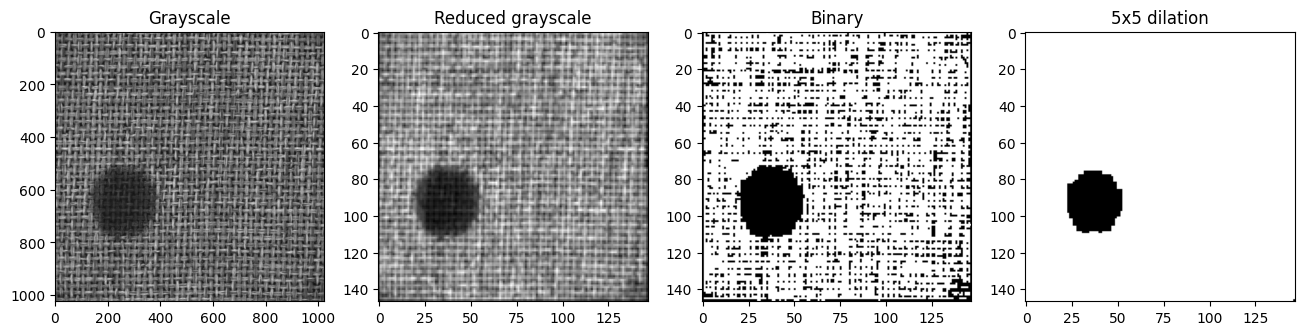

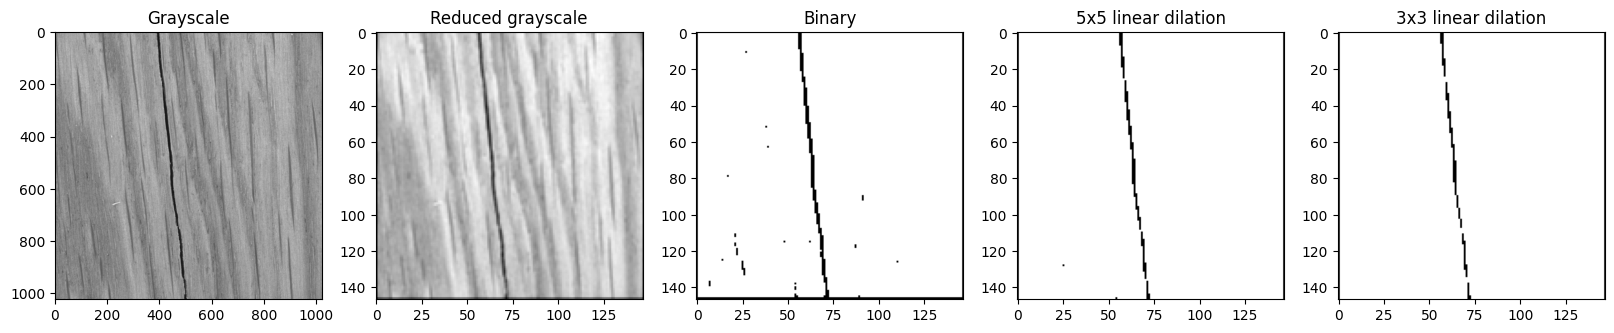

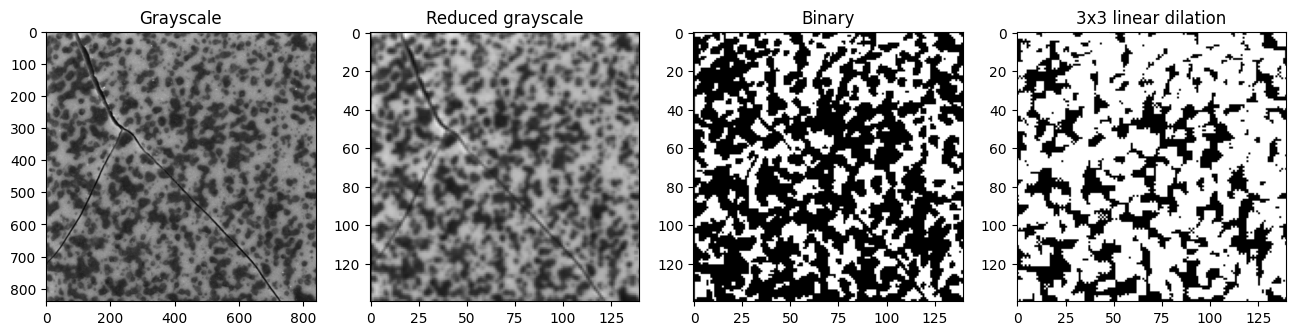

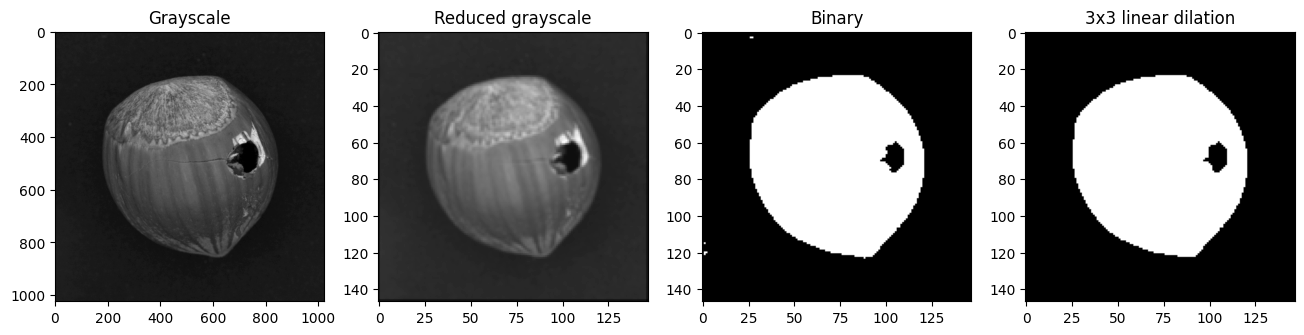

In [ ]:
# Iterate over list of lists of urls and list of pipeline
for defect_type, pipeline, threshold in zip(defect_type_list, pipeline_list, threshold_list):
    # Iterate over each image for each defect
    for image_path in defect_type:
        # Calling pipeline
        images, names = pipeline(image_path, threshold)

        # Plotting
        fig, axs = plt.subplots(1, len(images), figsize=(4 * (len(images)), 4 * 80))
        for i, image, name in zip(range(len(images)), images, names):
            axs[i].imshow(image, cmap = 'gray')
            axs[i].set_title(name)
        plt.show()

## Watermarking


#### Objective:
Use any of the previous techniques to apply a hard-to-removal watermark from to an image. After that you will try to reverse-engeneer your method and try to extract the text of the watermark you created.

---

#### Guideline:
1. Define a pipeline using the previous techniques (linear filtering, fourier transform, non-linear filtering, morphological operations, ...). You can use one or a combination of different techniques to produce a good pipeline.
2. Try to develop a method to extract the watermark (binary mask with the original watermark you introduced) by using the watermaked image and the original image.
3. Same as the previous one but relying only on the watermarked image. (You can't use the original image)
---

#### Expected results:
- A function that takes an image and a watermark (a binary image or a text) and returns the watermarked image.
- A pair of original image and the watermaked one
- A pair of a watermarked image and the watermark extracted (by using both original and watermaked image)
- A pair of a watermarked image and the watermark extracted (by using only the watermaked image)

In [ ]:
def apply_watermark(image, watermark_image, watermark_text=None):
    pass

def remove_watermark_easy(original_image, watermarked_image):
  pass

def remove_watermark_hard(watermarked_image):
  pass

## Watermark extraction challenge


#### Objective:
Create a binary mask where you can read the text of the watermark hidden on images on folder ```lab2_challenge```.  
Remember that this challenge counts as extra part of the lab and do not count of the optional points of this lab, so there's no guideline. Instead there's a hint on each level you can use to start designing your own method.


---

#### Hints:
  - Hints for each image:
    - Easy: Will edges and some post-processing be enough?
    - Medium: Equalizing the image correclty could make watermark more visible
    - Hard: Do you think image looks wierd enough to check fourier spece?

---

#### Expected results:
- A binary image with the extracted text (or at least somewhat readable) and the string of text you extracted on each one.